# Project Description:

A project from E-commerce domain.

# Context:

Everyday a million products are being recommended to users based on popularity and other metrics on e-commerce websites. The most popular e-commerce website boosts average order value by 50%, increases revenues by 300% and improves conversion. In addition to being a powerful tool for increasing revenues, product recommendations are so essential that customers now expect to see similar features on all other eCommerce sites.

# Data Description:

Data columns- First three columns are **userId**, **productId**, and **ratings** and the fourth column is **timestamp**. 

Source - Amazon Reviews data (http://jmcauley.ucsd.edu/data/amazon/). The repository has several datasets. For this case study, we are using the Electronics dataset.

# Objective:

To make a recommendation system that recommends at least five(5) new products based on the user's habits.

### Import necessary libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import json
import time
import collections
import joblib

from scipy.sparse.linalg import svds

from surprise import Dataset, Reader
from surprise import SVD, NormalPredictor, BaselineOnly, SVDpp, NMF

from surprise import accuracy
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split

In [3]:
ratings_data = pd.read_csv('ratings_Electronics.csv')
ratings_data.columns = ['UserId', 'ProductId', 'Ratings', 'Timestamp']

#### First five entries of the dataset

In [4]:
ratings_data.head()

,UserId,ProductId,Ratings,Timestamp
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600


It shows that there are four variables in the dataset - **UserId**, **ProductId**, **Ratings** and **Timestamp**.

## Exploratory Data Quality Report

In [5]:
ratings_data.shape

(7824481, 4)

The two-dimensional dataframe i.e., ratings_data consists of 7824481 rows and 4 columns.

#### Dataframe of each attribute

In [6]:
ratings_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824481 entries, 0 to 7824480
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   UserId     object 
 1   ProductId  object 
 2   Ratings    float64
 3   Timestamp  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 238.8+ MB


The attributes **UserId** and **ProductId** are qualitative in nature whereas **Ratings** and **Timestamp** are quantitative in nature.

#### Missing values in the dataset

In [7]:
ratings_data.isnull().sum()

UserId       0
ProductId    0
Ratings      0
Timestamp    0
dtype: int64

Thus, we can see that none of the attributes have any null values in them.

In [8]:
ratings_data = ratings_data.drop('Timestamp', axis = 1)
ratings_data.head()

,UserId,ProductId,Ratings
0,A2CX7LUOHB2NDG,0321732944,5.0
1,A2NWSAGRHCP8N5,0439886341,1.0
2,A2WNBOD3WNDNKT,0439886341,3.0
3,A1GI0U4ZRJA8WN,0439886341,1.0
4,A1QGNMC6O1VW39,0511189877,5.0


We have dropped **Timestamp** from the dataset as we believe that here it won't affect the recommendation.

#### 5 point summary of the numerical attributes

In [9]:
ratings_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Ratings,7824481.0,4.012337,1.38091,1.0,3.0,5.0,5.0,5.0


- It gives the descriptive statistics (mean, mode, median, percentiles, min, max and standard deviation) and count of **Ratings**.
- The minimum ratings that a user has given to a product is 1 whereas the maximum is 5. The average value of ratings for 7824481 entries is 4.012337 where 25% of the entries have a value below 3.0 and 50% have value below 5.0 and 75% have value below 5.0. The observations differ from the mean by 1.38091

## Description of independent attributes

#### UserId

In [10]:
print("The number of unique USERS in the dataset is =", ratings_data['UserId'].nunique())

The number of unique USERS in the dataset is = 4201696


In [11]:
print("The top 10 users who have rated the most products are = \n", ratings_data.groupby('UserId').size().sort_values(ascending = False)[:10])

The top 10 users who have rated the most products are = 
 UserId
A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
A1ODOGXEYECQQ8    380
A36K2N527TXXJN    314
A2AY4YUOX2N1BQ    311
AWPODHOB4GFWL     308
A25C2M3QF9G7OQ    296
dtype: int64


In [12]:
print("The top 10 users who have rated the least products are = \n", ratings_data.groupby('UserId').size().sort_values(ascending = True)[:10])

The top 10 users who have rated the least products are = 
 UserId
A00000262KYZUE4J55XGL    1
A3AAXWHVCN6VOG           1
A3AAXX0N47FFP            1
A3AAXY0TMZS72Y           1
A3AAXZAK8EB9KG           1
A3AAY0GAXS0XNA           1
A3AAY3OP8Z7FTA           1
A3AAY5WI5T8HN5           1
A3AAYE1Y83YT2P           1
A3AAYH5F5Z1VIG           1
dtype: int64


From the above two statements it is clear that:
- There isn't any user who haven't rated any of the listed products
- The highest number of product rated by a user is 520 whereas the least number of product rated by any user is 1
- The most number of products has been rated by **A5JLAU2ARJ0BO** who has rated 520 products followed by **ADLVFFE4VBT8** and **A3OXHLG6DIBRW8** who has rated 501 and 498 products respectively.

#### ProductId

In [13]:
print("The number of unique PRODUCTS in the dataset is = ", ratings_data['ProductId'].nunique())

The number of unique PRODUCTS in the dataset is =  476001


In [14]:
print('The top 10 most rated products are = \n', ratings_data.groupby('ProductId').size().sort_values(ascending = False)[:10])

The top 10 most rated products are = 
 ProductId
B0074BW614    18244
B00DR0PDNE    16454
B007WTAJTO    14172
B0019EHU8G    12285
B006GWO5WK    12226
B003ELYQGG    11617
B003ES5ZUU    10276
B007R5YDYA     9907
B00622AG6S     9823
B0002L5R78     9487
dtype: int64


In [15]:
print('The top 10 least rated products are = \n', ratings_data.groupby('ProductId').size().sort_values(ascending = True)[:10])

The top 10 least rated products are = 
 ProductId
0321732944    1
B0058FM05U    1
B0058FM0M8    1
B0058FM320    1
B0058FM5IM    1
B0058FOLWU    1
B0058FS2DO    1
B0058FTDQE    1
B0058FU57U    1
B0058FUM3C    1
dtype: int64


From the above two statements it is clear that:
- There isn't any products which haven't been rated by any of the users
- The highest number of ratings received by a product is 18244 whereas the least number of ratings received by any products is 1
- The most number of ratings has been received by the product **B0074BW614**. It has has received 18244 ratings followed by **B00DR0PDNE** and **B007WTAJTO** which has received 16454 and 14172 ratings respectively.

#### Ratings

We already know that the products has been rated on a scale of 1.0 to 5.0

The skewness in Ratings is given by =  -1.2053970002793784


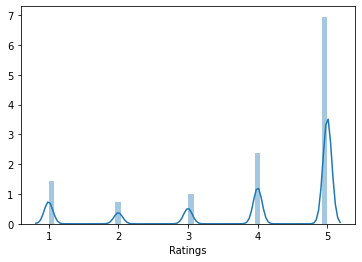

In [16]:
sns.distplot(ratings_data['Ratings'], kde = True)
print('The skewness in Ratings is given by = ', ratings_data['Ratings'].skew())

The observations in **Ratings** are left skewed.

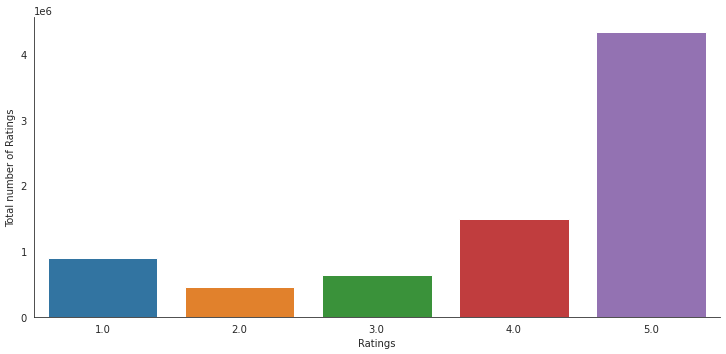

In [17]:
# Check the distribution of 'Ratings':
with sns.axes_style('white'):
    g = sns.factorplot("Ratings", data = ratings_data, aspect = 2.0, kind = 'count')
    g.set_ylabels("Total number of Ratings")

In [18]:
print('The distribution of the ratings is as follows = \n', ratings_data.groupby('Ratings').size().sort_values(ascending = False))

The distribution of the ratings is as follows = 
 Ratings
5.0    4347540
4.0    1485781
1.0     901765
3.0     633073
2.0     456322
dtype: int64


It is clear from the above plot that 4347540 products has been rated 5.0, 1485781 products has been rated 4.0, 901765 products has been rated 1.0, 633073 products has been rated 3.0 and 456322 products has been rated 2.0.

### Data Model Preparation

We will use a subset of the dataset to make it less sparse. For ease of operations we will consider only those users who have atleast rated 50 products.

In [19]:
counts1 = pd.value_counts(ratings_data['UserId'])

In [20]:
ratings_data = ratings_data[ratings_data['UserId'].isin(counts1[counts1 >= 50].index)]

In [21]:
ratings_data.head()

,UserId,ProductId,Ratings
93,A3BY5KCNQZXV5U,0594451647,5.0
117,AT09WGFUM934H,0594481813,3.0
176,A32HSNCNPRUMTR,0970407998,1.0
177,A17HMM1M7T9PJ1,0970407998,4.0
491,A3CLWR1UUZT6TG,0972683275,5.0


In [22]:
ratings_data.shape

(125871, 3)

The new dataset (after selecting users who have rated atleast 50 products) contains 125871 rows and 3 columns. 

In [23]:
print("The number of unique USERS in the dataset is =", ratings_data['UserId'].nunique())

The number of unique USERS in the dataset is = 1540


In [24]:
print("The top 10 users who have rated the most products are = \n", ratings_data.groupby('UserId').size().sort_values(ascending = False)[:10])

The top 10 users who have rated the most products are = 
 UserId
A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
A1ODOGXEYECQQ8    380
A36K2N527TXXJN    314
A2AY4YUOX2N1BQ    311
AWPODHOB4GFWL     308
A25C2M3QF9G7OQ    296
dtype: int64


In [25]:
print("The top 10 users who have rated the least products are = \n", ratings_data.groupby('UserId').size().sort_values(ascending = True)[:10])

The top 10 users who have rated the least products are = 
 UserId
A2RS66Y79Q8X0W    50
A2Y4H3PXB07WQI    50
A3VZH0PWLQ9BB1    50
A19N3S7CBSU6O7    50
A1IU4UAV9QIJAI    50
A319Y83RT0MRVR    50
A27H61OHW44XA7    50
A2JRDFIGWTX50J    50
A2RGA7UGAN3UL7    50
ACH055GTTIGC9     50
dtype: int64


From the new dataset it is clear that:
- The highest number of product rated by any user is still 520 whereas the least number of product rated by any user is 50 (which was our aim)
- The most number of products has been rated by **A5JLAU2ARJ0BO** who has rated 520 products followed by **ADLVFFE4VBT8** and **A3OXHLG6DIBRW8** who has rated 501 and 498 products respectively
- There are atleast ten users who have rated 50 products.

In [26]:
print("The number of unique PRODUCTS in the dataset is = ", ratings_data['ProductId'].nunique())

The number of unique PRODUCTS in the dataset is =  48190


In [27]:
print("The top 10 products which have been rated the most are = \n", ratings_data.groupby('ProductId').size().sort_values(ascending = False)[:10])

The top 10 products which have been rated the most are = 
 ProductId
B0088CJT4U    206
B003ES5ZUU    184
B000N99BBC    167
B007WTAJTO    164
B00829TIEK    149
B008DWCRQW    137
B00829THK0    137
B002R5AM7C    128
B004CLYEDC    118
B002SZEOLG    113
dtype: int64


In [28]:
print("The top 10 products which have been rated least are = \n", ratings_data.groupby('ProductId').size().sort_values(ascending = True)[:10])

The top 10 products which have been rated least are = 
 ProductId
0594451647    1
B004AAPKTW    1
B004AAZXQM    1
B004AB02IA    1
B004AB1OS2    1
B004AB35NY    1
B004AB3GJM    1
B004A9DHMK    1
B004AB715W    1
B004ABHKZ8    1
dtype: int64


From the new dataset it is clear that:
- The highest number of ratings received by a product is now 206 (which was earlier 18244) and the least number of ratings received by any products is still 1
- The most number of ratings has been received by the product **B0088CJT4U**. It has has received 206 ratings followed by **B003ES5ZUU** and **B000N99BBC**.

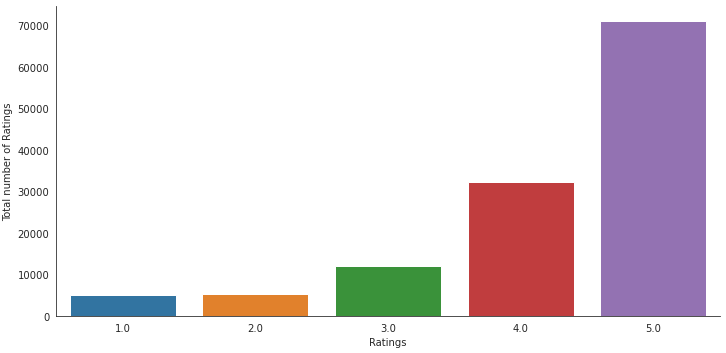

In [29]:
# Check the distribution of 'Ratings':
with sns.axes_style('white'):
    g = sns.factorplot("Ratings", data = ratings_data, aspect = 2.0, kind = 'count')
    g.set_ylabels("Total number of Ratings")

In [30]:
print('The distribution of the ratings is as follows = \n', ratings_data.groupby('Ratings').size().sort_values(ascending = False))

The distribution of the ratings is as follows = 
 Ratings
5.0    71034
4.0    32295
3.0    12060
2.0     5367
1.0     5115
dtype: int64


Thus, in the new dataset products rated 5.0 are the most (71034) followed by 4.0 (32295), 3.0 (12060), 2.0 (5367) and 1.0 (5115).

### Build Popularity Recommender Model (Non-Personalized)

In [31]:
# Count of UserId for each unique ProductId as Recommendation Score
ratings_data_grouped = ratings_data.groupby('ProductId').agg({'UserId': 'count'}).reset_index()
ratings_data_grouped.rename(columns = {'UserId': 'Score'}, inplace = True)
ratings_data_grouped.head()

,ProductId,Score
0,0594451647,1
1,0594481813,1
2,0970407998,2
3,0972683275,4
4,1400501466,6


In [32]:
# Sort the products on recommendation score
ratings_data_sort = ratings_data_grouped.sort_values(['Score', 'ProductId'], ascending = [0,1])

# Generate a recommendation rank based upon score
ratings_data_sort['Rank'] = ratings_data_sort['Score'].rank(ascending = 0, method = 'first')

# Get the top 5 recommendations
popularity_recommendations = ratings_data_sort.head(5)
popularity_recommendations

,ProductId,Score,Rank
39003,B0088CJT4U,206,1.0
24827,B003ES5ZUU,184,2.0
11078,B000N99BBC,167,3.0
38250,B007WTAJTO,164,4.0
38615,B00829TIEK,149,5.0


So, for any User the top 5 products that will be recommended are: **B0088CJT4U**, **B003ES5ZUU**, **B000N99BBC**, **B007WTAJTO** and **B00829TIEK**.

The top 5 recommendations for any user (based on Popularity Based Recommender System) will be the above mentioned ProductId as they have received the top 5 scores among the all the listed Products which will be verified when we will try to recommend products for a specific users.

#### Use Popularity Based Recommender model to make predictions and find recommendations for random list of users with inferences 

In [33]:
# Use popularity based Recommender Model to make Predictions
def recommend(UserId):
    user_recommendations = popularity_recommendations
    
    #Add UserId column for which the recommendations are being generated
    user_recommendations['UserId'] = UserId
    
    #Bring UserId column to the front
    cols = user_recommendations.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    user_recommendations = user_recommendations[cols]
    
    return user_recommendations

In [34]:
find_recommendation = [15,121,53] #This list is user choice
for i in find_recommendation:
    print('Here is the recommendation for the UserId: %d\n' %(i))
    print(recommend(i))
    print('\n')

Here is the recommendation for the UserId: 15

       UserId   ProductId  Score  Rank
39003      15  B0088CJT4U    206   1.0
24827      15  B003ES5ZUU    184   2.0
11078      15  B000N99BBC    167   3.0
38250      15  B007WTAJTO    164   4.0
38615      15  B00829TIEK    149   5.0


Here is the recommendation for the UserId: 121

       UserId   ProductId  Score  Rank
39003     121  B0088CJT4U    206   1.0
24827     121  B003ES5ZUU    184   2.0
11078     121  B000N99BBC    167   3.0
38250     121  B007WTAJTO    164   4.0
38615     121  B00829TIEK    149   5.0


Here is the recommendation for the UserId: 53

       UserId   ProductId  Score  Rank
39003      53  B0088CJT4U    206   1.0
24827      53  B003ES5ZUU    184   2.0
11078      53  B000N99BBC    167   3.0
38250      53  B007WTAJTO    164   4.0
38615      53  B00829TIEK    149   5.0




Thus, we can see that a Popularity Based Recommendation System always recommends the same set of the products to all the users i.e., it is a non-personalized recommendation system. 

### Building Collaborative Filtering Model

In this we will be using SVD to make necessary predictions. SVD will be used in two ways. In the first option we will be using SVD using mathematical operation (i.e., without using SVD from Surprise) and without splitting the dataset into trainset and testset.

In the second method we will be using SVD (from Surprise, a Python scikit for building and analyzing recommender systems that deal with explicit rating data). In this we will be dividing our ratings_data dataset into training and testing dataset and thereafter we will try to predict recommendations on test set.

After that we will try to benchmark some of the algorithms from Surprise: NormalPredictor (a Basic Algorithm from Surprise which predicts a random rating assuming that the distribution of the dataset is Normal), BaselineOnly( a Basic algorithm from Surprise algorithm which predicts the baseline estimate for given user and item), and then two matrix factorization based algorithms - SVD and SVDpp (takes into account implicit ratings).

### SVD

In [35]:
# Actual Ratings matrix:
final_ratings_matrix = ratings_data.pivot(index = 'UserId', columns = 'ProductId', values = 'Ratings').fillna(0)
print('Shape of final_ratings_matrix:', final_ratings_matrix.shape)

given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]

density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print('Density of the matrix is = {:4.2f}%'.format(density))

Shape of final_ratings_matrix: (1540, 48190)
Density of the matrix is = 0.17%


The density of the matrix is just 0.17%.

In [36]:
final_ratings_matrix.head()

ProductId,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
UserId,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
# Matrix with one row per 'Product' and one columns per 'User' for Item-based CF
final_ratings_matrix_T = final_ratings_matrix.transpose()
final_ratings_matrix_T.head()

UserId,A100UD67AHFODS,A100WO06OQR8BQ,A105S56ODHGJEK,A105TOJ6LTVMBG,A10AFVU66A79Y1,A10H24TDLK2VDP,A10NMELR4KX0J6,A10O7THJ2O20AG,A10PEXB6XAQ5XF,A10X9ME6R66JDX,...,AYOTEJ617O60K,AYP0YPLSP9ISM,AZ515FFZ7I2P7,AZ8XSDMIX04VJ,AZAC8O310IK4E,AZBXKUH4AIW3X,AZCE11PSTCH1L,AZMY6E8B52L2T,AZNUHQSHZHSUE,AZOK5STV85FBJ
ProductId,,,,,,,,,,,,,,,,,,,,,
0594451647,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0594481813,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0970407998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0972683275,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1400501466,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
# Matrix with row per 'user' and column per 'item'
ratings_data_pivot = ratings_data.pivot(index = 'UserId', columns = 'ProductId', values = 'Ratings').fillna(0)
print("The shape of User-Item Matrix is = ", ratings_data_pivot.shape)
ratings_data_pivot.head()

The shape of User-Item Matrix is =  (1540, 48190)


ProductId,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
UserId,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
ratings_data_pivot['user_index'] = np.arange(0, ratings_data_pivot.shape[0], 1)
ratings_data_pivot.head()

ProductId,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8,user_index
UserId,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [40]:
ratings_data_pivot.set_index(['user_index'], inplace = True)

#Actual Ratings given by users:
ratings_data_pivot.head()

ProductId,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
U, sigma, Vt = svds(ratings_data_pivot, k = 10)
sigma = np.diag(sigma)

In [42]:
all_user_predicted_rating = np.dot(np.dot(U, sigma), Vt)

#predicted rating:
ratings_data_predicted = pd.DataFrame(all_user_predicted_rating, columns = ratings_data_pivot.columns)
ratings_data_predicted.head()

ProductId,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
0,0.002661,0.003576,0.004050,0.006906,0.003967,0.003073,0.005782,0.000568,0.014386,0.002708,...,6.108890e-04,0.044224,0.002919,0.060347,-0.002137,0.006751,0.001525,0.130951,0.059243,0.015014
1,0.002262,0.002505,0.005136,0.016517,0.007120,0.001438,0.013258,0.000335,-0.003781,0.001190,...,2.024793e-04,0.029213,0.000010,0.000244,-0.003111,-0.000621,0.004409,-0.039241,-0.006889,0.003696
2,-0.001600,-0.002502,0.002186,0.016742,0.006716,-0.002113,0.005805,0.003497,-0.005009,-0.001588,...,-3.240446e-04,0.009180,-0.002459,-0.016922,0.019936,-0.002483,-0.000155,-0.002889,-0.011522,-0.004525
3,0.002732,0.003867,0.001799,0.009395,0.004075,0.002778,0.003507,0.000095,0.007983,0.002381,...,6.031462e-04,-0.003369,0.003433,-0.003428,-0.000750,0.000119,0.002612,-0.015107,-0.006740,0.003276
4,0.000704,0.000085,0.002051,0.009664,0.004438,0.000335,0.005992,0.001056,-0.000369,0.000373,...,3.745108e-08,-0.001140,-0.000323,-0.025215,0.004700,-0.002170,0.001263,-0.048555,-0.016301,-0.003377


#### Evaluation of Model Based Collaborative Filtering SVD

In [43]:
# Actual ratings given by the users. It is similar to the ratings_data_pivot. Only difference between the two is that ratings_data_pivot has UserId as index.:
final_ratings_matrix.head()

ProductId,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
UserId,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
# Predicted Ratings
ratings_data_predicted.head()

ProductId,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
0,0.002661,0.003576,0.004050,0.006906,0.003967,0.003073,0.005782,0.000568,0.014386,0.002708,...,6.108890e-04,0.044224,0.002919,0.060347,-0.002137,0.006751,0.001525,0.130951,0.059243,0.015014
1,0.002262,0.002505,0.005136,0.016517,0.007120,0.001438,0.013258,0.000335,-0.003781,0.001190,...,2.024793e-04,0.029213,0.000010,0.000244,-0.003111,-0.000621,0.004409,-0.039241,-0.006889,0.003696
2,-0.001600,-0.002502,0.002186,0.016742,0.006716,-0.002113,0.005805,0.003497,-0.005009,-0.001588,...,-3.240446e-04,0.009180,-0.002459,-0.016922,0.019936,-0.002483,-0.000155,-0.002889,-0.011522,-0.004525
3,0.002732,0.003867,0.001799,0.009395,0.004075,0.002778,0.003507,0.000095,0.007983,0.002381,...,6.031462e-04,-0.003369,0.003433,-0.003428,-0.000750,0.000119,0.002612,-0.015107,-0.006740,0.003276
4,0.000704,0.000085,0.002051,0.009664,0.004438,0.000335,0.005992,0.001056,-0.000369,0.000373,...,3.745108e-08,-0.001140,-0.000323,-0.025215,0.004700,-0.002170,0.001263,-0.048555,-0.016301,-0.003377


In [45]:
# Average Predicted rating for each item
ratings_data_predicted.mean().head()

ProductId
0594451647    0.001542
0594481813    0.002341
0970407998    0.002597
0972683275    0.011807
1400501466    0.004848
dtype: float64

In [46]:
rmse_df = pd.concat([final_ratings_matrix.mean(), ratings_data_predicted.mean()], axis = 1)
rmse_df.columns = ['Average_Actual_Ratings', 'Average_Predicted_Ratings']
print(rmse_df.shape)
rmse_df['item_index'] = np.arange(0, rmse_df.shape[0], 1)
rmse_df.head()

(48190, 2)


,Average_Actual_Ratings,Average_Predicted_Ratings,item_index
ProductId,,,
0594451647,0.003247,0.001542,0
0594481813,0.001948,0.002341,1
0970407998,0.003247,0.002597,2
0972683275,0.012338,0.011807,3
1400501466,0.012987,0.004848,4


In [47]:
RMSE = round((((rmse_df.Average_Actual_Ratings - rmse_df.Average_Predicted_Ratings) ** 2).mean() ** 0.5), 5)
print('\nRMSE SVD Model = {} \n'.format(RMSE))


RMSE SVD Model = 0.0033 



The accuracy score for this model which was given by RMSE is 0.0033

#### Use Collaborative Filter Based Recommender model to make predictions and find recommendations for random users with highest predicted ratings 

In [48]:
# Recommend the items with the highest predicted ratings
def recommend_items_collab_svd(UserId, ratings_data_pivot, ratings_data_predicted, num_recommendations):
    user_idx = UserId - 1 # index starts with 0
    
    # Get and sort the user's ratings
    sorted_user_ratings = ratings_data_pivot.iloc[user_idx].sort_values(ascending = False)
    
    # Sorted user ratings
    sorted_user_predictions = ratings_data_predicted.iloc[user_idx].sort_values(ascending = False)
    
    # Sorted user predictions
    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis = 1)
    temp.index.name = "Recommend Items"
    temp.columns = ['UserRatings', 'UserPredictions']
    
    temp = temp.loc[temp.UserRatings == 0]
    temp = temp.sort_values('UserPredictions', ascending = False)
    print('\nBelow are the Recommended items for User(User_Id = {}):\n'.format(UserId))
    print(temp.head(num_recommendations))

In [49]:
#Enter 'userID' and 'num_recommendations' for the user #
UserId = 15
num_recommendations = 5
recommend_items_collab_svd(UserId, ratings_data_pivot, ratings_data_predicted, num_recommendations)


Below are the Recommended items for User(User_Id = 15):

                 UserRatings  UserPredictions
Recommend Items                              
B007WTAJTO               0.0         0.247331
B003ES5ZUU               0.0         0.196123
B002V88HFE               0.0         0.133789
B002WE6D44               0.0         0.112403
B000QUUFRW               0.0         0.111686


In [50]:
#Enter 'userID' and 'num_recommendations' for the user #
UserId = 121
num_recommendations = 5
recommend_items_collab_svd(UserId, ratings_data_pivot, ratings_data_predicted, num_recommendations)


Below are the Recommended items for User(User_Id = 121):

                 UserRatings  UserPredictions
Recommend Items                              
B007WTAJTO               0.0         0.419325
B003ES5ZUU               0.0         0.372930
B002V88HFE               0.0         0.280845
B001TH7GUU               0.0         0.233768
B002WE6D44               0.0         0.216767


In [51]:
#Enter 'userID' and 'num_recommendations' for the user #
UserId = 53
num_recommendations = 5
recommend_items_collab_svd(UserId, ratings_data_pivot, ratings_data_predicted, num_recommendations)


Below are the Recommended items for User(User_Id = 53):

                 UserRatings  UserPredictions
Recommend Items                              
B007WTAJTO               0.0         0.311538
B003ES5ZUU               0.0         0.310841
B002V88HFE               0.0         0.198001
B001TH7GUU               0.0         0.183487
B002WE6D44               0.0         0.150186


Here, we can see that for user 15 "BB000QUUFRW" is recommended specifically whereas for user(User_Id) 121 and 53 product "B001TH7GUU" is recommended for both of them. Apart from this, all three of them have been recommended "B007WTAJTO", "B003ES5ZUU", "B002V88HFE" and "B002WE6D44" 

### Surprise and SVD

In [52]:
reader = Reader(rating_scale = (1,10))
ratings_data_Sur_SVD = Dataset.load_from_df(ratings_data[['UserId', 'ProductId', 'Ratings']], reader)

In [53]:
ratings_train, ratings_test = train_test_split(ratings_data_Sur_SVD, test_size = 0.3, random_state = 1)

In [54]:
ratings_train.all_ratings()

<generator object Trainset.all_ratings at 0x000001BD070D1B48>

In [55]:
# Obtaining the raw id
print(ratings_train.to_raw_uid(0))

A2CIQEY05SPHTZ


In [56]:
svd_model = SVD(n_factors = 5, biased = False)
svd_model.fit(ratings_train)

In [57]:
ratings_test[0]

('A3PDWA32BAMB2Y', 'B00CGW74YU', 5.0)

In [58]:
test_pred = svd_model.test(ratings_test)

In [59]:
# compute RMSE
accuracy.rmse(test_pred)

RMSE: 1.6032


1.6031993594558194

The accuracy of the model based on RMSE is 1.60

#### Use SVD to make predictions and find recommendations for random users with highest predicted ratings 

In [60]:
def get_top_n(test_pred, n):
    # First map the predictions to each user:
    top_n = collections.defaultdict(list)
    for uid, iid, true_r, est, _ in test_pred:
        top_n[uid].append((iid, est))
        
    # Then sort the predictions for each user and retrieve the k highest ones:
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse = True)
        top_n[uid] = user_ratings[:n]
        
    return top_n

In [61]:
top_n = get_top_n(test_pred, n = 5)

In [62]:
top_n

defaultdict(list,
            {'A3PDWA32BAMB2Y': [('B004W2JKWG', 5.649475138253148),
              ('B000Q8UAWY', 4.575733555536324),
              ('B000PNGM18', 4.268614425121315),
              ('B002U7NYYK', 4.259735100841004),
              ('B005E2K8K6', 4.259735100841004)],
             'A31BD4RXCON7QO': [('B0011NVMO8', 5.084847517560893),
              ('B001KELVS0', 4.679885168291806),
              ('B00009XVCZ', 4.678253917433535),
              ('B00007E7JU', 4.633753562283429),
              ('B000VUIXOO', 4.613584188281312)],
             'A3J8A5L5AF5TX9': [('B0012MMW7E', 5.599059088141292),
              ('B0001Y7UAI', 5.524529469611544),
              ('B000BQ7GW8', 5.48987318407202),
              ('B001W28L2Y', 5.362684712792498),
              ('B001ID829O', 5.029510924306521)],
             'A3D6OI36USYOU1': [('B001SJVU24', 5.219267825737804),
              ('B0035ERKYW', 5.1740928123546475),
              ('B003ES5ZUU', 4.452315696419522),
              ('B000A1790

Here, we have predicted the top 5 recommendations for each of the user on the basis of ratings. For e.g., for UserId "A3PDWA32BAMB2Y" recommendend items will be 'B004W2JKWG', 'B000Q8UAWY', 'B000PNGM18', 'B002U7NYYK' and 'B005E2K8K6'.

### Using SVD, SVDpp, NormalPredictor and BaselineOnly from Surprise

Here we will use cross validate to determine the best algorithm for the dataset and then using the a set of hyperparameter to train and test the model in order to predict the items for recommendation.

In [63]:
benchmark = []
# Iterate over all algorithms

for algorithm in [SVD(), SVDpp(), NormalPredictor(), BaselineOnly()]:
    # perform cross validation
    result = cross_validate(algorithm, ratings_data_Sur_SVD, measures = ['RMSE'], cv = 3, verbose = False)
    
    #Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(result).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


In [64]:
surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')

In [65]:
surprise_results

,test_rmse,fit_time,test_time
Algorithm,,,
BaselineOnly,0.982110,0.321002,0.197814
SVDpp,0.986078,71.578126,2.795772
SVD,0.987323,4.492276,0.348401
NormalPredictor,1.503066,0.143640,0.425538


As, BaselineOnly has the best performance since it has the least RMSE, therefore we will be training and predicting with BaselineOnly and use Alternating Least Square (ALS). 

In [66]:
print('Using ALS')
bsl_options = {'method': 'als',
               'n_epochs': 5,
               'reg_u': 12,
               'reg_i': 5
               }
algo = BaselineOnly(bsl_options=bsl_options)
cross_validate(algo, ratings_data_Sur_SVD, measures=['RMSE'], cv=3, verbose=False)

Using ALS
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


{'test_rmse': array([0.98111432, 0.97694087, 0.98552324]),
 'fit_time': (0.16356515884399414, 0.18959474563598633, 0.1825263500213623),
 'test_time': (0.18051457405090332, 0.1825110912322998, 0.17952370643615723)}

In [67]:
trainset, testset = train_test_split(ratings_data_Sur_SVD, test_size=0.3)
algo = BaselineOnly(bsl_options=bsl_options)
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)

Estimating biases using als...
RMSE: 0.9758


0.9758274124233489

So, the new and improved accuracy based on RMSE is 0.9758

#### Use BaselineOnly to make predictions and find recommendations for random users with highest predicted ratings 

In [68]:
def get_top_n_baseline(predictions, n):
    # First map the predictions to each user:
    top_n_baseline = collections.defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n_baseline[uid].append((iid, est))
        
    # Then sort the predictions for each user and retrieve the k highest ones:
    for uid, user_ratings in top_n_baseline.items():
        user_ratings.sort(key=lambda x: x[1], reverse = True)
        top_n_baseline[uid] = user_ratings[:n]
        
    return top_n_baseline

In [69]:
top_n_baseline = get_top_n_baseline(predictions, n = 5)

In [70]:
top_n_baseline

defaultdict(list,
            {'A3D6OI36USYOU1': [('B003ES5ZUU', 4.671436418001574),
              ('B0001G6U4S', 4.47107254451985),
              ('B001KB21KA', 4.302340233493692),
              ('B001SJVU24', 4.290937045285904),
              ('B004K2Z4MS', 4.28061694601943)],
             'A16RI68PS6T5CA': [('B000N99BBC', 4.588232159505509),
              ('B00COF7DGS', 4.3682767034842405),
              ('B000M2GYF6', 4.307656004086306),
              ('B00HVT27B8', 4.29443244101648),
              ('B0002TA96Y', 4.23179534203566)],
             'A1SB9BNNGKNX2Z': [('B005E8MVV4', 4.895919324121109),
              ('B004SKBJYE', 4.874972298699158),
              ('B000067RBT', 4.8581314395252395),
              ('B00GO4GMAI', 4.832216973072793),
              ('B00006JPDI', 4.799770279418388)],
             'ARBKYIVNYWK3C': [('B00080DSEM', 4.834488402257963),
              ('B0002WPREU', 4.823892339539962),
              ('B001AGM2VI', 4.8197914055917295),
              ('B0006I1TRY'

Here, we have predicted the top 5 recommendations for each of the user on the basis of ratings. For e.g., for UserId "A3D6OI36USYOU1" recommendend items will be 'B003ES5ZUU', 'B0001G6U4S', 'B001KB21KA', 'B001SJVU24' and 'B004K2Z4MS'.

### Summary

The activity involved designing a Recommendation System depending on the users' habit by using **Popularity Based** and **Collaborative Filtering**. The main points can be summarised in the following manner:

- **Popularity Based**:

It is a non-personalised recommendation system where the entire list of users are recommended the same set of products (as shown in the above for userid 15, 121 and 53). All three of them were recommended the same five set of the products -'B0088CJT4U', 'B003ES5ZUU', 'B000N99BBC', 'B007WTAJTO', 'B00829TIEK'. It is based on frequency counts, which may or may not be relevant to the user.

- **Collaborative Filtering**:

It is a personalised recommender system as the recommendations are based on the past behavior of the user. Although there are two types of Collaborative Filtering based system - Memory and Model Based. Here we have used Model based techniques - **SVD** to find a list of recommendations for the user. 

In first case where we tried just SVD, we can see that for user 15 "BB000QUUFRW" is recommended specifically whereas for user 121 and 53 product "B001TH7GUU" is recommended for both of them (although the propensity to be recommended differs as suggested by the expected ratings). Apart from this, all three of them have been recommended "B007WTAJTO", "B003ES5ZUU", "B002V88HFE" and "B002WE6D44".

In second case where we used SVD (from Surprise), we can see that from top_n (which contains the prediction value for the test set) that the users were mostly recommended different set of products based on their past behaviours.

In third case where we used BaselineOnly (from Surprise), we can see that from top_n_baseline (which contains the prediction value for the test set) that the users were mostly recommended different set of products based on their past behaviours.

Thus, from this activity it is clear that recommender system based **Collaborative Filtering** is more preferable than system based on **Popularity based** as before recommending items to a user it considers the past behaviour of the users.